In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp
#import ace_tools as tools  # if you want to display




In [55]:
#Data import - clean, seperate & filter
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
0,EOH0279,2020-10-26 00:00:00,00:00:00,NaN,0.000,0.000,0.008,9.38,23.14,23.35,...,EH22,00:00:00,8.90,6.10,79.75,5.6,0.154,0.0,0.0,19.30
1,EOH1703,2020-10-26 00:00:00,00:00:00,NaN,0.013,0.242,0.078,7.08,25.04,24.04,...,NE15,00:00:00,7.00,4.30,81.71,4.1,0.170,0.0,0.0,14.30
2,EOH1703,2020-10-26 00:30:00,00:30:00,NaN,0.029,0.622,0.212,6.83,25.43,24.23,...,NE15,00:30:00,6.95,4.05,81.93,4.1,0.085,0.0,0.0,15.85
3,EOH0279,2020-10-26 00:30:00,00:30:00,NaN,0.000,0.000,0.019,9.33,22.54,22.80,...,EH22,00:30:00,8.85,6.30,79.94,5.6,0.077,0.0,0.0,17.00
4,EOH0279,2020-10-26 01:00:00,01:00:00,NaN,0.000,2.730,0.967,9.21,35.27,30.93,...,EH22,01:00:00,8.80,6.50,80.13,5.6,0.000,0.0,0.0,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505054,EOH3154,2023-09-29 00:00:00,00:00:00,NaN,0.000,44801.768,14989.282,12.44,18.87,50.46,...,EH15,00:00:00,12.80,12.80,90.62,11.3,0.333,0.0,0.0,16.00
505055,EOH1637,2023-09-29 00:00:00,00:00:00,NaN,203.311,43996.381,13830.005,12.17,16.70,16.53,...,PH7,00:00:00,13.20,13.20,86.43,11.0,0.004,0.0,0.0,17.00
505056,EOH2329,2023-09-29 00:00:00,00:00:00,NaN,31.139,14128.100,5775.602,12.44,24.80,26.31,...,EH4,00:00:00,12.90,12.90,90.75,11.4,0.378,0.0,0.0,15.00
505057,EOH2675,2023-09-29 00:00:00,00:00:00,NaN,212.928,59675.471,19247.887,12.44,14.82,14.85,...,EH9,00:00:00,13.00,13.00,93.04,11.9,0.024,0.0,0.0,24.30


In [56]:
id_use = "EOH0279"
#id_use = "EOH1703"

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])
     


# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
print("Columns dropped due to high missing values:")
print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

print("\nColumns remaining after dropping highly missing columns:")
print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

print(f"\nNumber of rows dropped after handling NA values (missing for > 2 hours): {rows_dropped_after_interpolation}")


# 3. Split 80% to train and 20% to validate (based on time)
train_size = 0.8
split_point = int(len(df_single_processed) * train_size)

train_df = df_single_processed.iloc[:split_point].copy()
val_df = df_single_processed.iloc[split_point:].copy()

print(f"\nTrain data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Train data date range: {train_df.index.min()} to {train_df.index
      .max()}")
print(f"Validation data date range: {val_df.index.min()} to {val_df.index
.max()}")


# 4. Split the data between night and day
# Assuming night is from 10 PM (22:00) to 6 AM (06:00) AND SolarRadiation is 0.

# Extract hour from Timestamp
df_train_single = train_df.copy()
df_train_single['Hour'] = train_df.index.hour

# Define night and day conditions
# Condition 1: Time is between 10 PM and 6 AM
night_time_condition = (df_train_single['Hour'] >= 22) | \
                       (df_train_single['Hour'] < 6)

# Condition 2: Solar Irradiation is 0 (assuming 'SolarRadiation' is the correct column name)
if 'SolarRadiation' in df_train_single.columns:
    night_solar_condition = (df_train_single['SolarRadiation'] == 0)
    df_train_single['is_night'] = night_time_condition & night_solar_condition
else:
    print("\nWarning: 'SolarRadiation' column not found after preprocessing. Cannot use it for night/day split.")
    df_train_single['is_night'] = night_time_condition # Fallback to just time condition

day_df = df_train_single[df_train_single['is_night'] == False]
night_df = df_train_single[df_train_single['is_night'] == True]

print(f"\nDay data shape: {day_df.shape}")
print(f"Night data shape: {night_df.shape}")

print("\nExample of Day data head:")
print(day_df.head())
print("\nExample of Night data head:")
print(night_df.head())

Columns dropped due to high missing values:
['Back-up_Heater_Energy_Consumed', 'Boiler_Energy_Output', 'Brine_Flow_Temperature', 'Brine_Return_Temperature']

Columns remaining after dropping highly missing columns:
['Property_ID', 'Timestamp', 'half-hour', 'Circulation_Pump_Energy_Consumed', 'Heat_Pump_Energy_Output', 'Whole_System_Energy_Consumed', 'External_Air_Temperature', 'Heat_Pump_Heating_Flow_Temperature', 'Heat_Pump_Return_Temperature', 'Internal_Air_Temperature', 'Hot_Water_Flow_Temperature', 'Immersion_Heater_Energy_Consumed', 'Date', 'has_data', 'Heat_Pump_Energy_Output_Diff', 'Postcode', 'Time', 'Temperature', 'FeelsLike', 'Humidity', 'Dew', 'Precipitation', 'SolarRadiation', 'SolarEnergy', 'Windspeed', 'Internal_Temperature_Diff', 'Internal_Ambient_Temperature_Diff']

Number of rows dropped after handling NA values (missing for > 2 hours): 8

Train data shape: (41010, 26)
Validation data shape: (10253, 26)
Train data date range: 2020-10-26 00:00:00 to 2023-02-27 09:30:00


In [57]:
# Less than 18 C
df_heating_single = df_single_processed.copy()
#df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]


#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:00")
df_heating_annual = df_heating_single[df_heating_single.index>=t_start]
df_heating_annual = df_heating_annual[df_heating_annual.index<=t_end]

t_step = 30 # minutes
delta_t = t_step/60

T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a = (df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 



In [58]:
# Less than 18 C
df_heating_single = df_single_processed.copy()
#df_heating_single = [df_single_processed["External_Air_Temperature"]<=18]


#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 12 31 23:59:59")
df_heating_annual = df_heating_single[df_heating_single.index>=t_start]
df_heating_annual = df_heating_annual[df_heating_annual.index<=t_end]
df_heating_annual = df_heating_annual[
    (df_heating_annual.index<=t_mid_end) | (df_heating_annual
                                              .index>=t_mid_start)]
t_step = 30 # minutes
delta_t = t_step/60

T_a = (df_heating_annual["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i = (df_heating_annual["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a = (df_heating_annual["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i = (df_heating_annual["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp = (df_heating_annual["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar = (df_heating_annual["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind = (df_heating_annual["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 

In [59]:
# Less than 18 C
df_heating_single = df_single_processed.copy()

# Time range
t_start = pd.to_datetime("2022-6-01 00:00:00")
t_end = pd.to_datetime("2022-08-30 23:59:00")
df_DHW = df_heating_single[
    (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
].copy()

df_DHW.drop("Property_ID", axis=1, inplace=True)
df_DHW.drop("half-hour", axis=1, inplace=True)
df_DHW.drop("Date", axis=1, inplace=True)
df_DHW.drop("has_data", axis=1, inplace=True)

i = 24

df_numeric = df_DHW.select_dtypes(include='number')

# Resample and compute mean
df_resampled = df_numeric.resample(f'{i}h').mean()

df_DHW_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] <=0.15]

DHW_sum = []
DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum()*24

df_spc_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] >0.15]
SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum()*24

In [60]:
#Solves but can't constrain q_hp
'''
N = len(delta_T_i)

# Total heating energy (space conditioning) minus DHW
Q_sc = np.sum(q_hp) - 4075  # in kWh

# Known parameter
C = 7

phi_z = 2
phi_w = 2
phi = 10
# CVXPY variables
a = cp.Variable(pos=True)  #  a = 1/(R_a*C)
w_s = cp.Variable(nonneg=True)
w_w = cp.Variable(nonneg=True)
w   = cp.Variable()
e   = cp.Variable()
#z   = cp.Variable(N, nonneg=True)
q_hat = cp.Variable(N)

# Constraint: temperature dynamics match model
#model_rhs = (delta_T_a * a + q_hat + w_s * q_solar + w_w * 
#             delta_T_a * v_wind.T + w * np.ones(N,)) / C

model_rhs = (delta_T_a * a / C + q_hat / C + (w_s / C) * q_solar  + w_w * 
             delta_T_a * v_wind.T + w * np.ones(N,)) 

constraints = [
    cp.sum(q_hat) - Q_sc == e,
    delta_T_i == model_rhs,
    q_hat >= np.zeros(N,),
    q_hat <= 9, #q_hp + z,
    #w_s <= 3
]

# Objective: minimize squared error on energy balance
objective = cp.Minimize(
    e**2
    #+ phi_z*cp.norm2(z)
    #+ phi_w*w_w
    #+ phi * w 
    ) #+ cp.norm2(z))

# Solve
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI, verbose = True)
R_a = 1/a

# Output
print("Optimal R_a:", R_a.value)
print("w_s (solar gain):", w_s.value)
print("w_w (wind effect):", w_w.value)
print("w (bias):", w.value)
print("Q_hat total:", np.sum(q_hat.value))
print("Q_sc:", Q_sc)
print("Residual (e):", e.value)
'''

'\nN = len(delta_T_i)\n\n# Total heating energy (space conditioning) minus DHW\nQ_sc = np.sum(q_hp) - 4075  # in kWh\n\n# Known parameter\nC = 7\n\nphi_z = 2\nphi_w = 2\nphi = 10\n# CVXPY variables\na = cp.Variable(pos=True)  #  a = 1/(R_a*C)\nw_s = cp.Variable(nonneg=True)\nw_w = cp.Variable(nonneg=True)\nw   = cp.Variable()\ne   = cp.Variable()\n#z   = cp.Variable(N, nonneg=True)\nq_hat = cp.Variable(N)\n\n# Constraint: temperature dynamics match model\n#model_rhs = (delta_T_a * a + q_hat + w_s * q_solar + w_w * \n#             delta_T_a * v_wind.T + w * np.ones(N,)) / C\n\nmodel_rhs = (delta_T_a * a / C + q_hat / C + (w_s / C) * q_solar  + w_w * \n             delta_T_a * v_wind.T + w * np.ones(N,)) \n\nconstraints = [\n    cp.sum(q_hat) - Q_sc == e,\n    delta_T_i == model_rhs,\n    q_hat >= np.zeros(N,),\n    q_hat <= 9, #q_hp + z,\n    #w_s <= 3\n]\n\n# Objective: minimize squared error on energy balance\nobjective = cp.Minimize(\n    e**2\n    #+ phi_z*cp.norm2(z)\n    #+ phi_w*

In [61]:
'''
# compare q_hat with q_hp
plt.plot(df_heating_annual.index[:-1],q_hat.value, label = "q_optimize")
plt.plot(df_heating_annual.index[:-1],q_hp, label = "q_meas")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.show()
'''

'\n# compare q_hat with q_hp\nplt.plot(df_heating_annual.index[:-1],q_hat.value, label = "q_optimize")\nplt.plot(df_heating_annual.index[:-1],q_hp, label = "q_meas")\nplt.legend()\nplt.xlabel("Time")\nplt.ylabel("kWh")\nplt.show()\n'

In [62]:
# solves with error terms around dT_i and q_hp

N = len(delta_T_i)

# Total heating energy (space conditioning) minus DHW
Q_sc = np.sum(q_hp) - 4075 - SPC_sum + DHW_sum  # in kWh

# Known parameter
C = 7
phi_e = 0.1
phi_z = 0.001
phi_w = 2
phi_u = 2000
phi = 5
# CVXPY variables
a = cp.Variable(pos=True)  #  a = 1/(R_a*C)
w_s = cp.Variable(nonneg=True)
w_w = cp.Variable(nonneg=True)
w = cp.Variable()
e = cp.Variable()
z = cp.Variable(N, nonneg=True)
u = cp.Variable(N)
q_hat = cp.Variable(N)

# Constraint: temperature dynamics match model
model_rhs = (delta_T_a * a + q_hat + w_s * q_solar * T_a + w_w *
             delta_T_a @ v_wind.T + w * np.ones(N, )) / C

constraints = [
    cp.sum(q_hat) - Q_sc == e,
    delta_T_i + u == model_rhs,
    q_hat >= np.zeros(N, ),
    q_hat <= q_hp*delta_t + z,
    q_hat <= 9*delta_t,
    a >= 1/25
    #w_s <= 3
]

# Objective: minimize squared error on energy balance
objective = cp.Minimize(
    phi_e * e ** 2
    + phi_z * cp.norm2(z)
    + phi_u * cp.norm2(u)
    #+ phi_w*w_w
    #+ phi * w 
)  #+ cp.norm2(z))

# Solve
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.GUROBI, verbose=False)
R_a = 1 / a

rmse_dTi = np.sqrt(np.mean(u.value ** 2))
rmse_q_hp = np.sqrt(np.mean(z.value ** 2))

# Output
print("Optimal R_a:", R_a.value)
print("w_s (solar gain):", w_s.value)
print("w_w (wind effect):", w_w.value)
print("w (bias):", w.value)
print("Q_hat total:", np.sum(q_hat.value))
print("Q_sc:", Q_sc)
print("Residual (e):", e.value)
print("RMSE dTi:", rmse_dTi)
print("RMSE q_hat:", rmse_q_hp)

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 102 times so far.

  warnings.warn(msg, UserWarning)


Optimal R_a: 15.889540513619133
w_s (solar gain): 0.0
w_w (wind effect): 0.0
w (bias): -0.30824098752603063
Q_hat total: 5535.5761250962205
Q_sc: 5521.046999999999
Residual (e): 14.529125096188467
RMSE dTi: 0.25063440684951455
RMSE q_hat: 0.6503283568810302


In [63]:
def solve_inner_and_gradient(C):
    """Solve inner CVXPY problem for a given C, return rmse and gradient w.r.t C."""
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - 4075 - SPC_sum + DHW_sum

    # CVXPY variables
    a   = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    w_w = cp.Variable(nonneg=True)
    w   = cp.Variable()
    e   = cp.Variable()
    z   = cp.Variable(N, nonneg=True)
    u   = cp.Variable(N)
    q_hat = cp.Variable(N)

    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar * delta_T_a +
            w_w * delta_T_a @ v_wind.T + w * np.ones(N) * delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_hp + z,
        q_hat <= 9 ,
        a >= 1/25
    ]

    # Objective
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 2000
    objective = cp.Minimize(
        phi_e * e**2 +
        phi_z * cp.norm2(z) +
        phi_u * cp.norm2(u)
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=False)

    # Get values
    u_val = u.value
    expr_val = expr.value
    rmse = np.sqrt(np.mean(u_val**2))

    # Compute gradient analytically
    du_dC = -(expr_val) / (C**2)
    grad = (1 / (rmse * N)) * np.sum(u_val * du_dC)

    R_a = (1 / a.value) * delta_t
    return rmse, R_a, grad


# Gradient descent parameters
C = 6.0
alpha = 1
iters = 100
tol = 1e-4  # convergence tolerance on gradient


for i in range(iters):
    loss, R_a, grad = solve_inner_and_gradient(C)
    C -= alpha * grad
    print(f"Iter {i+1:02d}: C = {C:.4f}, R_a = {R_a:.4f}, rmse = {loss:.4f}, grad = {grad:.6f}")
    
    # Check convergence
    if abs(grad) < tol:
        print(f"✅ Converged after {i+1} iterations: |grad|={abs(grad):.6e}")
        break
else:
    print(f"⚠️ Exited after {iters} iterations (not fully converged). Final |grad|={abs(grad):.6e}")

/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 103 times so far.

  warnings.warn(msg, UserWarning)


Iter 01: C = 5.9835, R_a = 5.3247, rmse = 0.2154, grad = 0.016529


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 104 times so far.

  warnings.warn(msg, UserWarning)


Iter 02: C = 5.9671, R_a = 5.3238, rmse = 0.2156, grad = 0.016420


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 105 times so far.

  warnings.warn(msg, UserWarning)


Iter 03: C = 5.9501, R_a = 5.3243, rmse = 0.2142, grad = 0.016971


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 106 times so far.

  warnings.warn(msg, UserWarning)


Iter 04: C = 5.9331, R_a = 5.3232, rmse = 0.2139, grad = 0.017021


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 107 times so far.

  warnings.warn(msg, UserWarning)


Iter 05: C = 5.9159, R_a = 5.3233, rmse = 0.2136, grad = 0.017118


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 108 times so far.

  warnings.warn(msg, UserWarning)


Iter 06: C = 5.8988, R_a = 5.3224, rmse = 0.2133, grad = 0.017191


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 109 times so far.

  warnings.warn(msg, UserWarning)


Iter 07: C = 5.8815, R_a = 5.3208, rmse = 0.2130, grad = 0.017246


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 110 times so far.

  warnings.warn(msg, UserWarning)


Iter 08: C = 5.8644, R_a = 5.3208, rmse = 0.2132, grad = 0.017113


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 111 times so far.

  warnings.warn(msg, UserWarning)


Iter 09: C = 5.8470, R_a = 5.3195, rmse = 0.2125, grad = 0.017384


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 112 times so far.

  warnings.warn(msg, UserWarning)


Iter 10: C = 5.8295, R_a = 5.3182, rmse = 0.2121, grad = 0.017479


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 113 times so far.

  warnings.warn(msg, UserWarning)


Iter 11: C = 5.8119, R_a = 5.3189, rmse = 0.2118, grad = 0.017581


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 114 times so far.

  warnings.warn(msg, UserWarning)


Iter 12: C = 5.7943, R_a = 5.3160, rmse = 0.2115, grad = 0.017638


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 115 times so far.

  warnings.warn(msg, UserWarning)


Iter 13: C = 5.7767, R_a = 5.3161, rmse = 0.2114, grad = 0.017654


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 116 times so far.

  warnings.warn(msg, UserWarning)


Iter 14: C = 5.7589, R_a = 5.3166, rmse = 0.2109, grad = 0.017806


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 117 times so far.

  warnings.warn(msg, UserWarning)


Iter 15: C = 5.7409, R_a = 5.3144, rmse = 0.2105, grad = 0.017904


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 118 times so far.

  warnings.warn(msg, UserWarning)


Iter 16: C = 5.7230, R_a = 5.3153, rmse = 0.2102, grad = 0.017987


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 119 times so far.

  warnings.warn(msg, UserWarning)


Iter 17: C = 5.7049, R_a = 5.3142, rmse = 0.2099, grad = 0.018065


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 120 times so far.

  warnings.warn(msg, UserWarning)


Iter 18: C = 5.6868, R_a = 5.3146, rmse = 0.2097, grad = 0.018097


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 121 times so far.

  warnings.warn(msg, UserWarning)


Iter 19: C = 5.6686, R_a = 5.3119, rmse = 0.2093, grad = 0.018214


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 122 times so far.

  warnings.warn(msg, UserWarning)


Iter 20: C = 5.6502, R_a = 5.3121, rmse = 0.2089, grad = 0.018346


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 123 times so far.

  warnings.warn(msg, UserWarning)


Iter 21: C = 5.6318, R_a = 5.3088, rmse = 0.2086, grad = 0.018395


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 124 times so far.

  warnings.warn(msg, UserWarning)


Iter 22: C = 5.6135, R_a = 5.3089, rmse = 0.2086, grad = 0.018337


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 125 times so far.

  warnings.warn(msg, UserWarning)


Iter 23: C = 5.5949, R_a = 5.3087, rmse = 0.2079, grad = 0.018621


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 126 times so far.

  warnings.warn(msg, UserWarning)


Iter 24: C = 5.5762, R_a = 5.3078, rmse = 0.2075, grad = 0.018705


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 127 times so far.

  warnings.warn(msg, UserWarning)


Iter 25: C = 5.5575, R_a = 5.3045, rmse = 0.2075, grad = 0.018649


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 128 times so far.

  warnings.warn(msg, UserWarning)


Iter 26: C = 5.5386, R_a = 5.3052, rmse = 0.2068, grad = 0.018905


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 129 times so far.

  warnings.warn(msg, UserWarning)


Iter 27: C = 5.5196, R_a = 5.3028, rmse = 0.2065, grad = 0.019005


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 130 times so far.

  warnings.warn(msg, UserWarning)


Iter 28: C = 5.5005, R_a = 5.3022, rmse = 0.2061, grad = 0.019111


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 131 times so far.

  warnings.warn(msg, UserWarning)


Iter 29: C = 5.4813, R_a = 5.2984, rmse = 0.2057, grad = 0.019215


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 132 times so far.

  warnings.warn(msg, UserWarning)


Iter 30: C = 5.4621, R_a = 5.2991, rmse = 0.2055, grad = 0.019237


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 133 times so far.

  warnings.warn(msg, UserWarning)


Iter 31: C = 5.4427, R_a = 5.2950, rmse = 0.2051, grad = 0.019344


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 134 times so far.

  warnings.warn(msg, UserWarning)


Iter 32: C = 5.4232, R_a = 5.2967, rmse = 0.2046, grad = 0.019503


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 135 times so far.

  warnings.warn(msg, UserWarning)


Iter 33: C = 5.4042, R_a = 5.2950, rmse = 0.2056, grad = 0.018985


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 136 times so far.

  warnings.warn(msg, UserWarning)


Iter 34: C = 5.3845, R_a = 5.2933, rmse = 0.2038, grad = 0.019737


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 137 times so far.

  warnings.warn(msg, UserWarning)


Iter 35: C = 5.3646, R_a = 5.2912, rmse = 0.2034, grad = 0.019850


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 138 times so far.

  warnings.warn(msg, UserWarning)


Iter 36: C = 5.3448, R_a = 5.2854, rmse = 0.2032, grad = 0.019873


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 139 times so far.

  warnings.warn(msg, UserWarning)


Iter 37: C = 5.3254, R_a = 5.2886, rmse = 0.2043, grad = 0.019319


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 140 times so far.

  warnings.warn(msg, UserWarning)


Iter 38: C = 5.3055, R_a = 5.2852, rmse = 0.2028, grad = 0.019919


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 141 times so far.

  warnings.warn(msg, UserWarning)


Iter 39: C = 5.2852, R_a = 5.2854, rmse = 0.2019, grad = 0.020298


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 142 times so far.

  warnings.warn(msg, UserWarning)


Iter 40: C = 5.2648, R_a = 5.2804, rmse = 0.2014, grad = 0.020423


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 143 times so far.

  warnings.warn(msg, UserWarning)


Iter 41: C = 5.2443, R_a = 5.2817, rmse = 0.2010, grad = 0.020548


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 144 times so far.

  warnings.warn(msg, UserWarning)


Iter 42: C = 5.2238, R_a = 5.2741, rmse = 0.2010, grad = 0.020490


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 145 times so far.

  warnings.warn(msg, UserWarning)


Iter 43: C = 5.2031, R_a = 5.2719, rmse = 0.2004, grad = 0.020675


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 146 times so far.

  warnings.warn(msg, UserWarning)


Iter 44: C = 5.1822, R_a = 5.2751, rmse = 0.1997, grad = 0.020923


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 147 times so far.

  warnings.warn(msg, UserWarning)


Iter 45: C = 5.1611, R_a = 5.2710, rmse = 0.1993, grad = 0.021038


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 148 times so far.

  warnings.warn(msg, UserWarning)


Iter 46: C = 5.1400, R_a = 5.2697, rmse = 0.1990, grad = 0.021118


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 149 times so far.

  warnings.warn(msg, UserWarning)


Iter 47: C = 5.1190, R_a = 5.2621, rmse = 0.1990, grad = 0.021015


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 150 times so far.

  warnings.warn(msg, UserWarning)


Iter 48: C = 5.0978, R_a = 5.2612, rmse = 0.1984, grad = 0.021204


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 151 times so far.

  warnings.warn(msg, UserWarning)


Iter 49: C = 5.0763, R_a = 5.2635, rmse = 0.1976, grad = 0.021521


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 152 times so far.

  warnings.warn(msg, UserWarning)


Iter 50: C = 5.0546, R_a = 5.2606, rmse = 0.1971, grad = 0.021702


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 153 times so far.

  warnings.warn(msg, UserWarning)


Iter 51: C = 5.0328, R_a = 5.2555, rmse = 0.1967, grad = 0.021793


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 154 times so far.

  warnings.warn(msg, UserWarning)


Iter 52: C = 5.0114, R_a = 5.2518, rmse = 0.1973, grad = 0.021395


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 155 times so far.

  warnings.warn(msg, UserWarning)


Iter 53: C = 4.9921, R_a = 5.2507, rmse = 0.2014, grad = 0.019242


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 156 times so far.

  warnings.warn(msg, UserWarning)


Iter 54: C = 4.9699, R_a = 5.2472, rmse = 0.1952, grad = 0.022279


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 157 times so far.

  warnings.warn(msg, UserWarning)


Iter 55: C = 4.9474, R_a = 5.2489, rmse = 0.1947, grad = 0.022436


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 158 times so far.

  warnings.warn(msg, UserWarning)


Iter 56: C = 4.9250, R_a = 5.2428, rmse = 0.1944, grad = 0.022452


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 159 times so far.

  warnings.warn(msg, UserWarning)


Iter 57: C = 4.9034, R_a = 5.2426, rmse = 0.1959, grad = 0.021589


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 160 times so far.

  warnings.warn(msg, UserWarning)


Iter 58: C = 4.8810, R_a = 5.2378, rmse = 0.1941, grad = 0.022382


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 161 times so far.

  warnings.warn(msg, UserWarning)


Iter 59: C = 4.8581, R_a = 5.2337, rmse = 0.1929, grad = 0.022934


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 162 times so far.

  warnings.warn(msg, UserWarning)


Iter 60: C = 4.8362, R_a = 5.2324, rmse = 0.1948, grad = 0.021822


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 163 times so far.

  warnings.warn(msg, UserWarning)


Iter 61: C = 4.8130, R_a = 5.2339, rmse = 0.1918, grad = 0.023274


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 164 times so far.

  warnings.warn(msg, UserWarning)


Iter 62: C = 4.7894, R_a = 5.2294, rmse = 0.1911, grad = 0.023550


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 165 times so far.

  warnings.warn(msg, UserWarning)


Iter 63: C = 4.7657, R_a = 5.2270, rmse = 0.1906, grad = 0.023699


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 166 times so far.

  warnings.warn(msg, UserWarning)


Iter 64: C = 4.7418, R_a = 5.2219, rmse = 0.1900, grad = 0.023879


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 167 times so far.

  warnings.warn(msg, UserWarning)


Iter 65: C = 4.7178, R_a = 5.2203, rmse = 0.1894, grad = 0.024071


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 168 times so far.

  warnings.warn(msg, UserWarning)


Iter 66: C = 4.6935, R_a = 5.2185, rmse = 0.1888, grad = 0.024266


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 169 times so far.

  warnings.warn(msg, UserWarning)


Iter 67: C = 4.6692, R_a = 5.2164, rmse = 0.1884, grad = 0.024324


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 170 times so far.

  warnings.warn(msg, UserWarning)


Iter 68: C = 4.6446, R_a = 5.2138, rmse = 0.1877, grad = 0.024575


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 171 times so far.

  warnings.warn(msg, UserWarning)


Iter 69: C = 4.6212, R_a = 5.2072, rmse = 0.1896, grad = 0.023384


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 172 times so far.

  warnings.warn(msg, UserWarning)


Iter 70: C = 4.5963, R_a = 5.2064, rmse = 0.1866, grad = 0.024888


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 173 times so far.

  warnings.warn(msg, UserWarning)


Iter 71: C = 4.5711, R_a = 5.2062, rmse = 0.1858, grad = 0.025224


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 174 times so far.

  warnings.warn(msg, UserWarning)


Iter 72: C = 4.5457, R_a = 5.2035, rmse = 0.1852, grad = 0.025410


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 175 times so far.

  warnings.warn(msg, UserWarning)


Iter 73: C = 4.5204, R_a = 5.1993, rmse = 0.1851, grad = 0.025297


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 176 times so far.

  warnings.warn(msg, UserWarning)


Iter 74: C = 4.4949, R_a = 5.1961, rmse = 0.1843, grad = 0.025554


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 177 times so far.

  warnings.warn(msg, UserWarning)


Iter 75: C = 4.4692, R_a = 5.1946, rmse = 0.1839, grad = 0.025654


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 178 times so far.

  warnings.warn(msg, UserWarning)


Iter 76: C = 4.4433, R_a = 5.1901, rmse = 0.1831, grad = 0.025944


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 179 times so far.

  warnings.warn(msg, UserWarning)


Iter 77: C = 4.4167, R_a = 5.1898, rmse = 0.1818, grad = 0.026514


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 180 times so far.

  warnings.warn(msg, UserWarning)


Iter 78: C = 4.3900, R_a = 5.1855, rmse = 0.1812, grad = 0.026705


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 181 times so far.

  warnings.warn(msg, UserWarning)


Iter 79: C = 4.3631, R_a = 5.1827, rmse = 0.1804, grad = 0.026978


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 182 times so far.

  warnings.warn(msg, UserWarning)


Iter 80: C = 4.3358, R_a = 5.1796, rmse = 0.1796, grad = 0.027223


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 183 times so far.

  warnings.warn(msg, UserWarning)


Iter 81: C = 4.3089, R_a = 5.1711, rmse = 0.1797, grad = 0.026964


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 184 times so far.

  warnings.warn(msg, UserWarning)


Iter 82: C = 4.2813, R_a = 5.1707, rmse = 0.1783, grad = 0.027612


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 185 times so far.

  warnings.warn(msg, UserWarning)


Iter 83: C = 4.2543, R_a = 5.1682, rmse = 0.1790, grad = 0.026972


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 186 times so far.

  warnings.warn(msg, UserWarning)


Iter 84: C = 4.2264, R_a = 5.1627, rmse = 0.1772, grad = 0.027860


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 187 times so far.

  warnings.warn(msg, UserWarning)


Iter 85: C = 4.1990, R_a = 5.1557, rmse = 0.1774, grad = 0.027472


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 188 times so far.

  warnings.warn(msg, UserWarning)


Iter 86: C = 4.1702, R_a = 5.1530, rmse = 0.1751, grad = 0.028707


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 189 times so far.

  warnings.warn(msg, UserWarning)


Iter 87: C = 4.1412, R_a = 5.1533, rmse = 0.1742, grad = 0.029027


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 190 times so far.

  warnings.warn(msg, UserWarning)


Iter 88: C = 4.1126, R_a = 5.1460, rmse = 0.1745, grad = 0.028592


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 191 times so far.

  warnings.warn(msg, UserWarning)


Iter 89: C = 4.0830, R_a = 5.1437, rmse = 0.1725, grad = 0.029599


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 192 times so far.

  warnings.warn(msg, UserWarning)


Iter 90: C = 4.0531, R_a = 5.1405, rmse = 0.1716, grad = 0.029911


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 193 times so far.

  warnings.warn(msg, UserWarning)


Iter 91: C = 4.0229, R_a = 5.1333, rmse = 0.1708, grad = 0.030195


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 194 times so far.

  warnings.warn(msg, UserWarning)


Iter 92: C = 3.9924, R_a = 5.1304, rmse = 0.1699, grad = 0.030502


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 195 times so far.

  warnings.warn(msg, UserWarning)


Iter 93: C = 3.9616, R_a = 5.1267, rmse = 0.1689, grad = 0.030856


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 196 times so far.

  warnings.warn(msg, UserWarning)


Iter 94: C = 3.9306, R_a = 5.1179, rmse = 0.1683, grad = 0.030931


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 197 times so far.

  warnings.warn(msg, UserWarning)


Iter 95: C = 3.8991, R_a = 5.1125, rmse = 0.1669, grad = 0.031517


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 198 times so far.

  warnings.warn(msg, UserWarning)


Iter 96: C = 3.8676, R_a = 5.1060, rmse = 0.1664, grad = 0.031553


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 199 times so far.

  warnings.warn(msg, UserWarning)


Iter 97: C = 3.8354, R_a = 5.1058, rmse = 0.1649, grad = 0.032211


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 200 times so far.

  warnings.warn(msg, UserWarning)


Iter 98: C = 3.8043, R_a = 5.0970, rmse = 0.1660, grad = 0.031082


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 201 times so far.

  warnings.warn(msg, UserWarning)


Iter 99: C = 3.7714, R_a = 5.0896, rmse = 0.1629, grad = 0.032890


/Users/levipremer/PycharmProjects/uk_data_electric_heating/.venv/lib/python3.12/site-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 202 times so far.

  warnings.warn(msg, UserWarning)


Iter 100: C = 3.7381, R_a = 5.0844, rmse = 0.1619, grad = 0.033236
⚠️ Exited after 100 iterations (not fully converged). Final |grad|=3.323578e-02


In [64]:
def solve_inner(C):
    """Solve inner CVXPY problem for a given C and return parameters + metrics."""
    N = len(delta_T_i)
    Q_sc = np.sum(q_hp) - 4075 - SPC_sum + DHW_sum

    # CVXPY variables
    a   = cp.Variable(pos=True)
    w_s = cp.Variable(nonneg=True)
    w_w = cp.Variable(nonneg=True)
    w   = cp.Variable()
    e   = cp.Variable()
    z   = cp.Variable(N, nonneg=True)
    u   = cp.Variable(N)
    q_hat = cp.Variable(N)

    # Expression
    expr = (delta_T_a * a * delta_t + q_hat + w_s * q_solar + w * np.ones
    (N) * delta_t)

    # Constraints
    constraints = [
        cp.sum(q_hat) - Q_sc == e,
        delta_T_i + u == expr / C,
        q_hat >= 0,
        q_hat <= q_hp + z,
        q_hat <= 9,
        a >= 1/30,
        a <= 1/5
    ]

    # Objective weights
    phi_e = 0.1
    phi_z = 0.001
    phi_u = 2000
    objective = cp.Minimize(
        phi_e * e**2 +
        phi_z * cp.norm2(z) +
        phi_u * cp.norm2(u) +
        phi_z * cp.maximum(0, -(q_hat+z)).sum()
    )

    prob = cp.Problem(objective, constraints)
    _ = prob.solve(solver=cp.GUROBI, verbose=False)

    # Extract values
    R_a = 1 / a.value 
    ws_val = w_s.value
    ww_val = w_w.value
    w_val = w.value
    q_hat_val = q_hat.value


    # RMSE for dTi (u)
    rmse_dTi = np.sqrt(np.mean(u.value**2))

    # RMSE for q_hat vs q_hp
    rmse_q = np.sqrt(np.mean((q_hat.value - q_hp * delta_t)**2))
    
    return R_a, ws_val, ww_val, w_val, rmse_q, rmse_dTi, q_hat_val


# Create time index for q_hat arrays
time_index = df_heating_annual.index[:-1]

# Initialize DataFrame to hold all q_hat results
df_q_results = pd.DataFrame(index=time_index)

# Grid search and store results
C_values = np.arange(1, 3.1, 0.1)
results = []

for C in C_values:
    R_a, ws, ww, w, rmse_q, rmse_dTi,q_hat_val = solve_inner(C)
    # Save q_hat for this C
    # Add q_hat as a new column
    df_q_results[f"C_{C:.1f}"] = q_hat_val
    
    results.append({
        "C": C,
        "R_a": R_a,
        "w_s": ws,
        #"w_w": ww,
        "w": w,
        "rmse_q": rmse_q,
        "rmse_dTi": rmse_dTi
    })
    print(f"C={C:.2f} | R_a={R_a:.4f} | w_s={ws:.4f} | w={w:.4f} | "
          f"rmse_q={rmse_q:.4f} | rmse_dTi={rmse_dTi:.4f}")

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Display or save
print(df_results.head())#%%
print(grad)


C=1.00 | R_a=15.6452 | w_s=0.0000 | w=-0.2864 | rmse_q=0.3606 | rmse_dTi=0.0195
C=1.10 | R_a=14.4328 | w_s=0.0000 | w=-0.2400 | rmse_q=0.3442 | rmse_dTi=0.0245
C=1.20 | R_a=13.5479 | w_s=0.0000 | w=-0.2009 | rmse_q=0.3310 | rmse_dTi=0.0301
C=1.30 | R_a=12.9181 | w_s=0.0000 | w=-0.1699 | rmse_q=0.3211 | rmse_dTi=0.0361
C=1.40 | R_a=12.4205 | w_s=0.0000 | w=-0.1431 | rmse_q=0.3145 | rmse_dTi=0.0425
C=1.50 | R_a=12.0038 | w_s=0.0000 | w=-0.1190 | rmse_q=0.3110 | rmse_dTi=0.0489
C=1.60 | R_a=11.6480 | w_s=0.0000 | w=-0.0970 | rmse_q=0.3104 | rmse_dTi=0.0554
C=1.70 | R_a=11.4077 | w_s=0.0000 | w=-0.0838 | rmse_q=0.3124 | rmse_dTi=0.0618
C=1.80 | R_a=11.2080 | w_s=0.0000 | w=-0.0731 | rmse_q=0.3167 | rmse_dTi=0.0681
C=1.90 | R_a=11.0284 | w_s=0.0000 | w=-0.0632 | rmse_q=0.3233 | rmse_dTi=0.0743
C=2.00 | R_a=10.8720 | w_s=0.0001 | w=-0.0549 | rmse_q=0.3317 | rmse_dTi=0.0804
C=2.10 | R_a=10.7361 | w_s=0.0001 | w=-0.0478 | rmse_q=0.3416 | rmse_dTi=0.0863
C=2.20 | R_a=10.6230 | w_s=0.0001 | w=-0

In [65]:
df_results.sort_values(by="rmse_dTi", ascending=True, inplace=True)
top_result = df_results.iloc[0]
top_result

C                           1.0
R_a                   15.645221
w_s                         0.0
w           -0.2864190084790293
rmse_q                 0.360572
rmse_dTi               0.019504
Name: 0, dtype: object

In [76]:
df_heating_single

,Property_ID,half-hour,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,Internal_Air_Temperature,Hot_Water_Flow_Temperature,...,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed,Internal_Temperature_Diff,Internal_Ambient_Temperature_Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-26 00:00:00,EOH0279,00:00:00,0.00,0.000,0.008,9.38,23.14,23.35,17.21,22.68,...,8.90,6.10,79.750,5.60,0.1540,0.0,0.0,19.30,-0.19,-7.83
2020-10-26 00:30:00,EOH0279,00:30:00,0.00,0.000,0.019,9.33,22.54,22.80,17.02,22.68,...,8.85,6.30,79.940,5.60,0.0770,0.0,0.0,17.00,-0.19,-7.69
2020-10-26 01:00:00,EOH0279,01:00:00,0.00,2.730,0.967,9.21,35.27,30.93,16.87,22.68,...,8.80,6.50,80.130,5.60,0.0000,0.0,0.0,14.70,-0.15,-7.66
2020-10-26 01:30:00,EOH0279,01:30:00,0.00,4.312,1.647,9.01,52.94,46.32,16.76,22.68,...,8.65,6.15,82.785,5.90,0.0000,0.0,0.0,15.75,-0.11,-7.75
2020-10-26 02:00:00,EOH0279,02:00:00,0.00,4.312,1.657,8.88,41.04,42.52,16.68,22.68,...,8.50,5.80,85.440,6.20,0.0000,0.0,0.0,16.80,-0.08,-7.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 22:00:00,EOH0279,22:00:00,86.84,29033.384,8687.249,13.39,23.06,23.19,17.87,55.42,...,14.20,14.20,79.140,10.60,0.0790,0.0,0.0,18.00,-0.04,-4.48
2023-09-28 22:30:00,EOH0279,22:30:00,86.84,29033.384,8687.259,13.08,22.80,22.92,17.76,55.42,...,13.75,13.75,83.800,11.05,0.3500,0.0,0.0,19.60,-0.11,-4.68
2023-09-28 23:00:00,EOH0279,23:00:00,86.84,29033.384,8687.270,12.77,22.59,22.68,17.72,55.42,...,13.30,13.30,88.460,11.50,0.6210,0.0,0.0,21.20,-0.04,-4.95


RMSE of q_hp: 1.0413116315095914


/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_30285/434870142.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_s=top_result[2]
/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_30285/434870142.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = top_result[3]


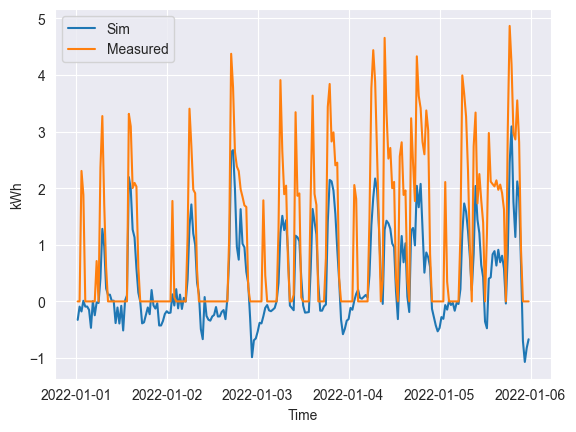

In [75]:
C = top_result[0]
R_a = top_result[1]
w_s=top_result[2]
w = top_result[3]


# Validate results
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_end = pd.to_datetime("2022 01 05 23:59:00")
df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]



T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_opt = df_q_opt[f"C_{C:.1f}"].iloc[:-1].reset_index(drop=True).to_numpy()
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 



q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  + w_s *  
         q_solar_val  + w * np.ones(len(T_a_val), )* delta_t )

e_q = q_hat_sim - q_hp_val
rmse_q_val = np.sqrt(np.mean(e_q**2))
print(f"RMSE of q_hp: {rmse_q_val}")

plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.show()



/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_30285/1312466956.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  C = top_result[0]
/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_30285/1312466956.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_a = top_result[1]
/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_30285/1312466956.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_s=top_result

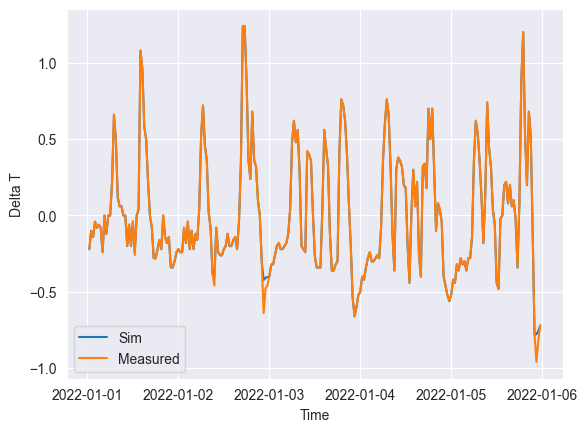

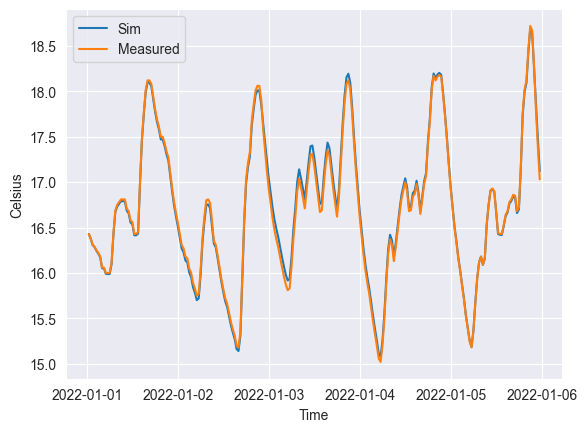

In [74]:
C = top_result[0]
R_a = top_result[1]
w_s=top_result[2]
w = top_result[3]


# Validate results
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_end = pd.to_datetime("2022 01 05 23:59:00")
df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]



T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_opt = df_q_opt[f"C_{C:.1f}"].iloc[:-1].reset_index(drop=True).to_numpy()
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 


delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_opt + w_s* q_solar_val + w
                 * np
                 .ones(len(T_a_val), )* delta_t) / C

T_i_sim = np.zeros_like(T_i_val)
T_i_prev = T_i_val[0]
for i in range(len(delta_T_i_sim)):
    T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
    T_i_prev = T_i_sim[i]


plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Delta T")
plt.show()

plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
         .iloc[1:].reset_index
       (drop=True).to_numpy(), label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Celsius")
plt.show()

In [68]:
q_hat.value

array([6.67236099e-08, 8.81774114e-08, 8.70854547e-08, ...,
       9.30310987e-08, 4.92987206e-08, 5.34196459e-08], shape=(13106,))

In [69]:
q_hp

array([0.   , 0.   , 2.304, ..., 0.   , 0.   , 0.   ], shape=(13106,))

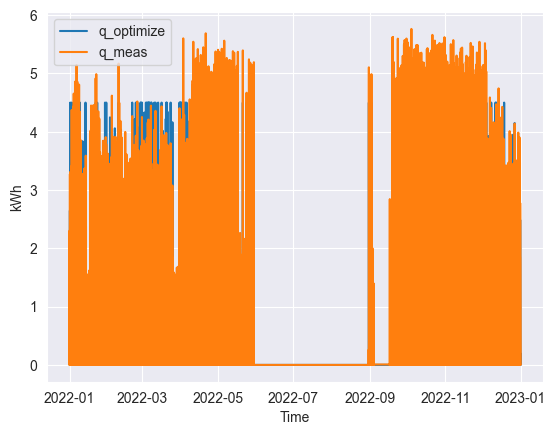

In [70]:
# compare q_hat with q_hp
plt.plot(df_heating_annual.index[:-1],q_hat.value, label = "q_optimize")
plt.plot(df_heating_annual.index[:-1],q_hp, label = "q_meas")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.show()

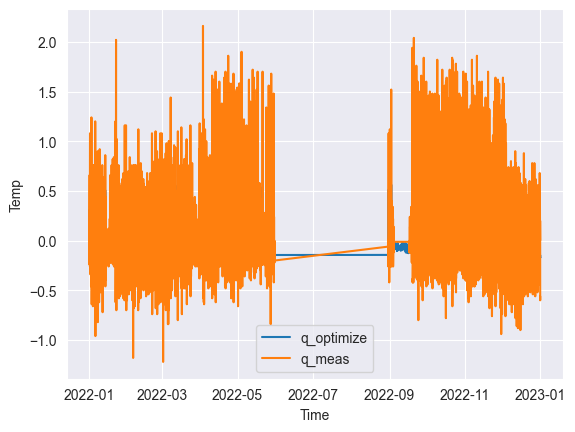

In [71]:
# compare delt T_i with u
plt.plot(df_heating_annual.index[1:],delta_T_i + u.value, label = 
"q_optimize")
plt.plot(df_heating_annual.index[1:],delta_T_i, label = "q_meas")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temp")
plt.show()

In [72]:
# Validate results
t_start = pd.to_datetime("2023 01 01 00:00:00")
t_end = pd.to_datetime("2023 01 03 23:59:00")
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]

T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 


delta_T_i_sim = (delta_T_a_val * a.value + q_hp_val + w_s.value * q_solar_val * 
                 T_a_val + w_w.value * delta_T_a_val @ v_wind_val.T + w.value 
                 * np
                 .ones(len(T_a_val), )) / C

T_i_sim = np.zeros_like(T_i_val)
T_i_prev = T_i_val[0]
for i in range(len(delta_T_i_sim)):
    print(i)
    T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
    T_i_prev = T_i_sim[i]

plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.show()

plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
         .iloc[1:].reset_index
       (drop=True).to_numpy(), label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Celsius")
plt.show()

AttributeError: 'numpy.float64' object has no attribute 'value'

In [122]:
delta_T_i_sim[0]

np.float64(-0.20043989445326418)

RMSE of q_hp: 1.2250702367243977


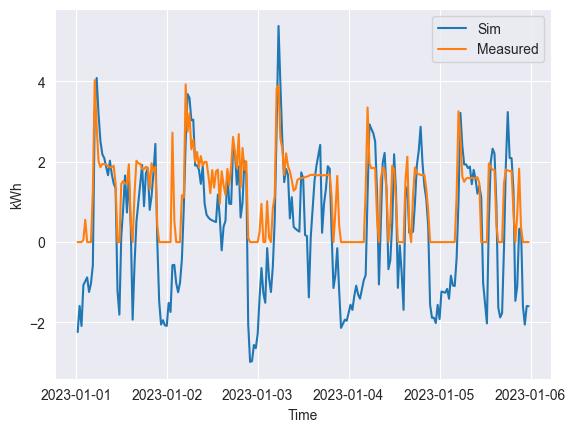

In [123]:
# Validate results
t_start = pd.to_datetime("2023 01 01 00:00:00")
t_end = pd.to_datetime("2023 01 5 23:59:00")
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]

T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 


q_hat_sim = (delta_T_i_val * C -  delta_T_a_val * a.value + w_s.value *  
         q_solar_val * T_a_val + w_w.value * delta_T_a_val @ v_wind_val.T + w
         .value * np.ones(len(T_a_val), ) )

e_q = q_hat_sim - q_hp_val
rmse_q_val = np.sqrt(np.mean(e_q**2))
print(f"RMSE of q_hp: {rmse_q_val}")

plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.show()

In [124]:
# Less than 18 C
df_heating_single = df_single_processed.copy()

# Time range
t_start = pd.to_datetime("2021-10-01 00:00:00")
t_end = pd.to_datetime("2022-03-31 23:59:00")
df_heating_only = df_heating_single[
    (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
].copy()

df_heating_only.drop("Property_ID", axis=1, inplace=True)
df_heating_only.drop("half-hour", axis=1, inplace=True)
df_heating_only.drop("Date", axis=1, inplace=True)
df_heating_only.drop("has_data", axis=1, inplace=True)



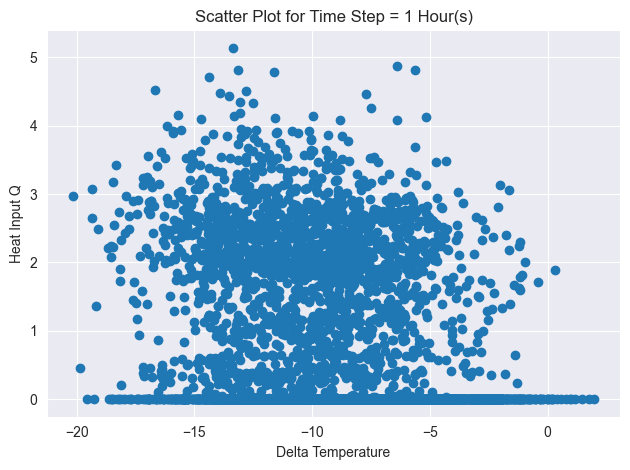

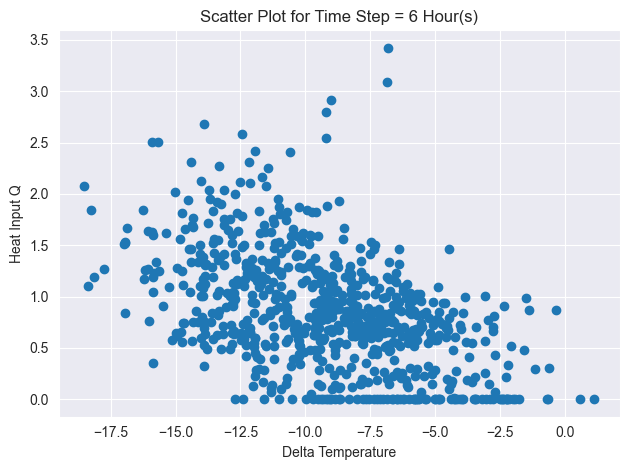

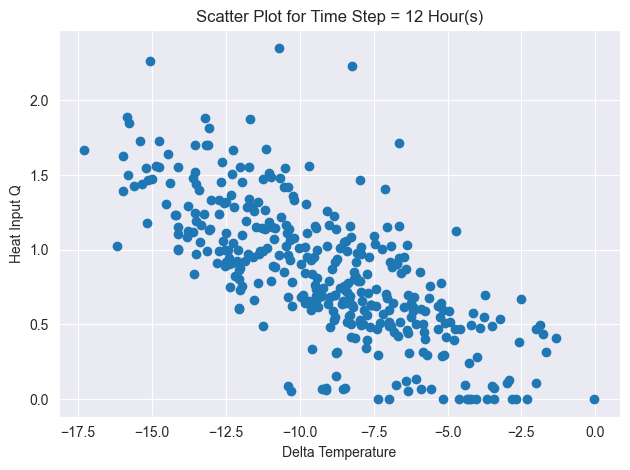

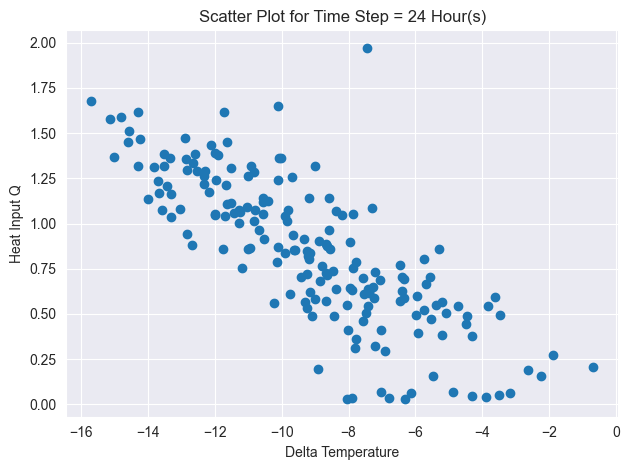

In [125]:

# Less than 18 C
df_heating_single = df_single_processed.copy()

# Time range
t_start = pd.to_datetime("2021-10-01 00:00:00")
t_end = pd.to_datetime("2022-03-31 23:59:00")
df_heating_only = df_heating_single[
    (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
].copy()

df_heating_only.drop("Property_ID", axis=1, inplace=True)
df_heating_only.drop("half-hour", axis=1, inplace=True)
df_heating_only.drop("Date", axis=1, inplace=True)
df_heating_only.drop("has_data", axis=1, inplace=True)


t_step_try = [1, 6, 12, 24]

for i in t_step_try:
    df_numeric = df_heating_only.select_dtypes(include='number')

    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()

    # Extract variables
    delta_T_a_heat = df_resampled["Internal_Ambient_Temperature_Diff"]
    q_heat_only = df_resampled["Heat_Pump_Energy_Output_Diff"]

    # Create new scatter plot
    plt.figure()
    plt.scatter(delta_T_a_heat, q_heat_only)
    plt.title(f"Scatter Plot for Time Step = {i} Hour(s)")
    plt.xlabel("Delta Temperature")
    plt.ylabel("Heat Input Q")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    


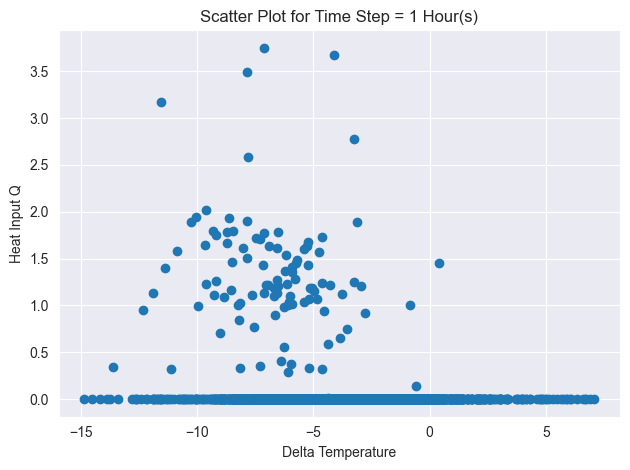

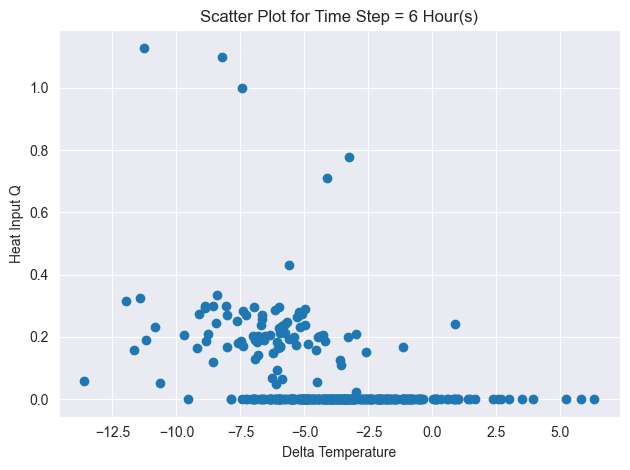

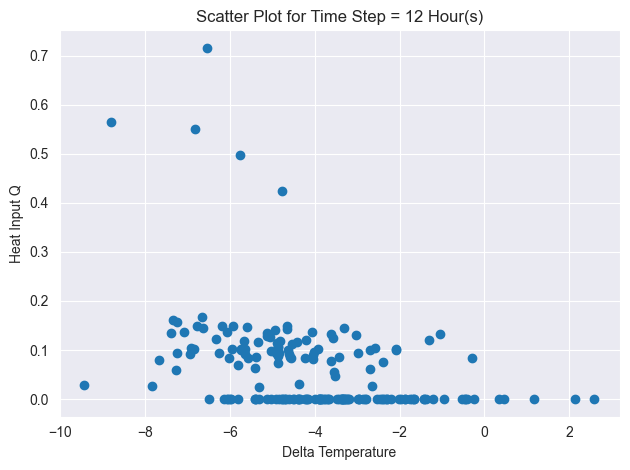

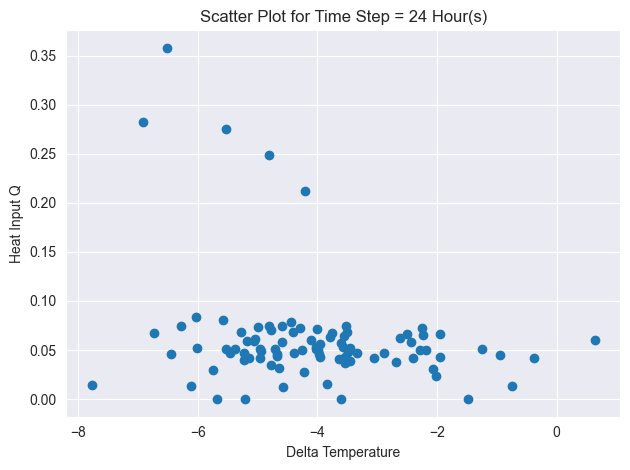

In [126]:
# Less than 18 C
df_heating_single = df_single_processed.copy()

# Time range
t_start = pd.to_datetime("2022-6-01 00:00:00")
t_end = pd.to_datetime("2022-08-30 23:59:00")
df_DHW = df_heating_single[
    (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
].copy()

df_DHW.drop("Property_ID", axis=1, inplace=True)
df_DHW.drop("half-hour", axis=1, inplace=True)
df_DHW.drop("Date", axis=1, inplace=True)
df_DHW.drop("has_data", axis=1, inplace=True)


t_step_try = [1, 6, 12, 24]

for i in t_step_try:
    df_numeric = df_DHW.select_dtypes(include='number')

    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()

    # Extract variables
    delta_T_a_heat = df_resampled["Internal_Ambient_Temperature_Diff"]
    q_heat_only = df_resampled["Heat_Pump_Energy_Output_Diff"]

    # Create new scatter plot
    plt.figure()
    plt.scatter(delta_T_a_heat, q_heat_only)
    plt.title(f"Scatter Plot for Time Step = {i} Hour(s)")
    plt.xlabel("Delta Temperature")
    plt.ylabel("Heat Input Q")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [127]:
i = 24

df_numeric = df_DHW.select_dtypes(include='number')

# Resample and compute mean
df_resampled = df_numeric.resample(f'{i}h').mean()

df_DHW_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] <=0.15]

DHW_sum = []
DHW_sum = df_DHW_only["Heat_Pump_Energy_Output_Diff"].sum()*24

df_spc_only = df_resampled[df_resampled["Heat_Pump_Energy_Output_Diff"] >0.15]
SPC_sum = df_spc_only["Heat_Pump_Energy_Output_Diff"].sum()*24

DHW_sum

np.float64(101.26949999999852)